# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Authors:** Dhruti Shah, Mahdi Nobar, Zahra Farsijani
**Due date:** 27.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html


In [1]:
import skimage.io
from skimage.color import rgb2hsv, hsv2rgb
import skimage.color
from scipy.spatial import distance
from matplotlib import path
from skimage.color import rgb2gray
from skimage.filters import gaussian
import cv2
import os, tarfile
import skimage.io
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_fill_holes
import skimage.filters
from skimage import measure
from skimage import morphology
from skimage.feature import canny
import scipy.ndimage as ndimage
from skimage.segmentation import active_contour
from scipy import ndimage as ndi
import numpy as np

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

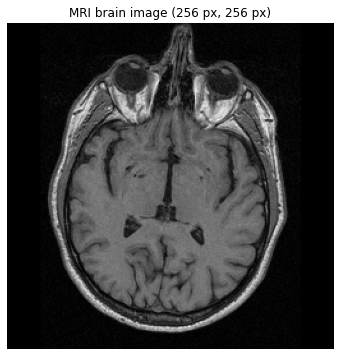

In [2]:

%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()



### 1.2 Region growing

The idea behing region growing is to choose an initial pixel, which is known to be inside the desired region, and then recursively check if its neighbors satisfy the homogenity criteria, and keep adding them to the region of interest if they do. 

Generally it is a good idea to pre-process the image with a Gaussian or Median filter. However, for region growing, this dilutes the distinction between the reion of iterest and the rest. (We also observed worse results if a Median/Gaussian filter was applied pre-processing). So, we introduce a post-processing step to refine the results obtained by region growing.

Using two different homogenity criterion for the region growing method:

    intensity > threshold
    intensity difference between neighbors < threshold

We obtain two different results from the above two different criterion, shown below.


In [3]:
# Intensity > threshold
def check_neighbors(seed_pt1, img, thresh, checked, mask):
    neigh = []
    seed_pt_i = seed_pt1[0]
    seed_pt_j = seed_pt1[1]
    for j in range(max(0,seed_pt_j-1),min(seed_pt_j+2,256)):
        for i in range(max(0,seed_pt_i-1),min(seed_pt_i+2,256)):
            if img[i][j].astype(int) > thresh and (i,j) not in checked and (i,j)!=(seed_pt_i, seed_pt_j):
            #if abs(img[i][j].astype(int)-img[seed_pt_i][seed_pt_j].astype(int)) < thresh and (i,j) not in checked and (i,j)!=(seed_pt_i, seed_pt_j):
                if (i,j) not in checked:
                    neigh += [(i,j)]
                    mask[i][j] = True
    return neigh, mask

def region_growing(mask, seed_pt, img, thresh):
    mask[seed_pt[0]][seed_pt[1]] = True
    to_check = [seed_pt]
    checked = []
    while(len(to_check)>0):
        neighbors = []
        for i in to_check:
            neigh, mask = check_neighbors(i, img, thresh, checked, mask)
            neighbors += neigh
            checked += neigh
        to_check = neighbors
    
    return mask

In [4]:
# Intensity difference between neighbors < threshold
def check_neighbors1(seed_pt1, img, thresh, checked, mask):
    neigh = []
    seed_pt_i = seed_pt1[0]
    seed_pt_j = seed_pt1[1]
    for j in range(max(0,seed_pt_j-1),min(seed_pt_j+2,256)):
        for i in range(max(0,seed_pt_i-1),min(seed_pt_i+2,256)):
            #if img[i][j].astype(int) > 69 and (i,j) not in checked and (i,j)!=(seed_pt_i, seed_pt_j):
            if abs(img[i][j].astype(int)-img[seed_pt_i][seed_pt_j].astype(int)) < thresh and (i,j) not in checked and (i,j)!=(seed_pt_i, seed_pt_j):
                if (i,j) not in checked:
                    neigh += [(i,j)]
                    mask[i][j] = True
    return neigh, mask

def region_growing1(mask, seed_pt, img, thresh):
    mask[seed_pt[0]][seed_pt[1]] = True
    to_check = [seed_pt]
    checked = []
    while(len(to_check)>0):
        neighbors = []
        for i in to_check:
            neigh, mask = check_neighbors1(i, img, thresh, checked, mask)
            neighbors += neigh
            checked += neigh
        to_check = neighbors
    
    return mask

In [5]:
mask = np.zeros([im_h, im_w]).astype(bool)
seed_pt = (im_h//2, im_w//2+20)
mask = region_growing(mask, seed_pt, brain_im, thresh=69)

mask1 = np.zeros([im_h, im_w]).astype(bool)
seed_pt = (im_h//2, im_w//2+20)
mask1 = region_growing1(mask1, seed_pt, brain_im, thresh=8)

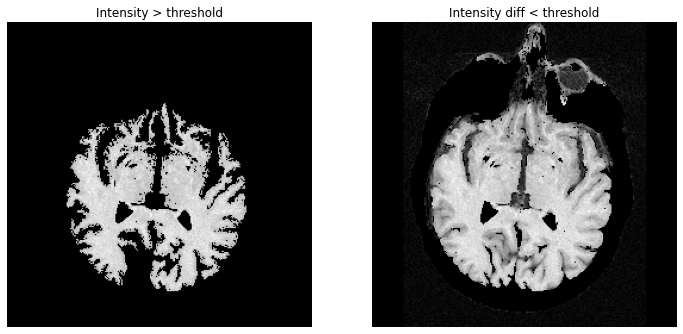

In [6]:
brain_im1 = brain_im.copy()
brain_im1[np.logical_not(mask)]=0

brain_im2 = brain_im.copy()
brain_im2[np.logical_not(mask1)]=0

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(brain_im1, cmap='gray')
ax[0].set_title('Intensity > threshold')
ax[0].axis('off')

ax[1].imshow(brain_im2, cmap='gray')
ax[1].set_title('Intensity diff < threshold')
ax[1].axis('off')

plt.show()

We see above the results obtained after region growing with the two different homogenity criterion.

#### Post - processing - thresholding and region detection

For the first image, we see that some parts of the brain are not detected. For the second one, we see that the entire brain in addition to other pixels are detected. We can correctly get only the brain pixels by post-processing the second image. 

We have 2 steps. Firstly, we threshold the image, to remove some of the unwanted components. Then we detect the connected components, and discard those whose size is smaller than a certain threshold. In this way, we get an accurate segment of the brain.

Step 1 - Thresholding 

We plot a histogram, and then take the threshold to the be midpoint between the two peaks, as discussed in class. This helps by removing the darker pixels, which we know correspond to the background and not the brain.


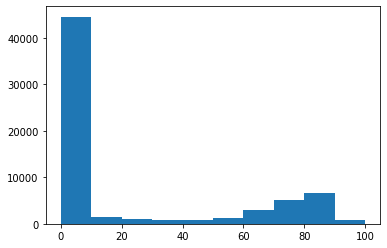

In [7]:
plt.hist(brain_im2.ravel());
plt.show()

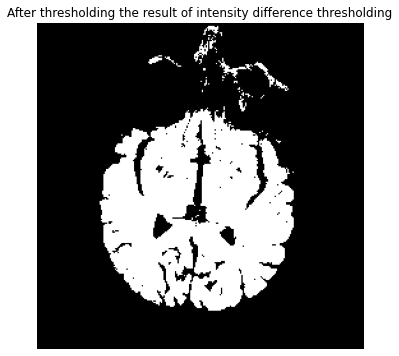

In [8]:
mask1 = brain_im2 > 50 #second region growing method is again been thresholded.

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(mask1, cmap='gray')
ax.set_title('After thresholding the result of intensity difference thresholding')
ax.axis('off')

plt.show()

Step 2 - Discarding the smaller components 

We now detect the connected components in the mask obtained after thresholding. Then, we discard the smaller ones, whose size is less than a certain threshold.


In [9]:
label_objects, nb_labels = ndi.label(mask1)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 80
mask_sizes[0] = 0
mask_cleaned = mask_sizes[label_objects]

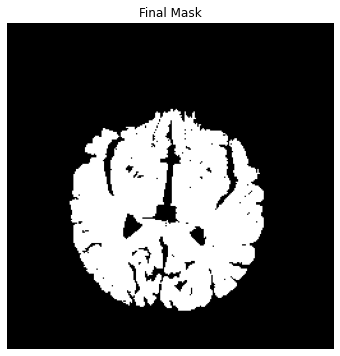

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(mask_cleaned, cmap='gray')
ax.set_title('Final Mask')
ax.axis('off')

plt.show()

In [11]:
print('Size of brain (in pixels) is:', np.sum(mask_cleaned))

Size of brain (in pixels) is: 16177


### 1.3 Contour detection

In this section, we use contour detection methods to obtain the brain from the image given. This is useful, since we know that the brain is separated from other parts of the head, by a connected contour.

For the first pre-processing step, we apply a Gaussian filter to remove the background noise.

We then do a thresholding to remove the background, and just have the parts of the head in the image. Next, we apply binary erosion, to separate the brain from parts of the skull.



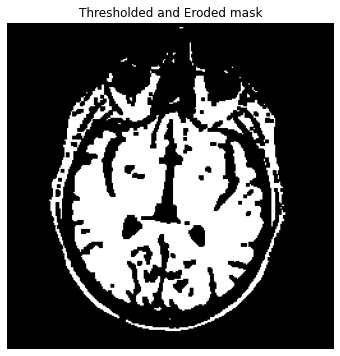

In [12]:
brain_im2 = skimage.filters.gaussian(brain_im,sigma=0.01)
mask = morphology.binary_erosion(brain_im2 > 0.2, selem=np.ones([3,3]))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(mask, cmap='gray')
ax.set_title('Thresholded and Eroded mask')
ax.axis('off')

plt.show()

Next, we do a contour detection. After getting all the countours, we would only like to keep the longest contour, which corresponds to the brain.

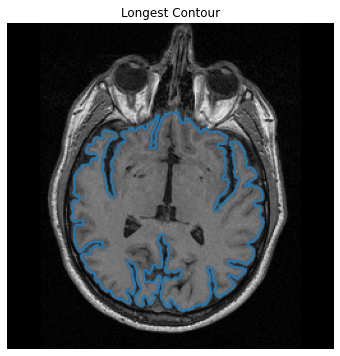

In [13]:
contours = measure.find_contours(mask, 0.24)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im2, cmap='gray')
ax.set_title('Longest Contour')
ax.axis('off')

max_len = 0
longest_c = contours[0]
index_longest = 0

for n, contour in enumerate(contours):
    if len(contour) > max_len:
        max_len = len(contour)
        longest_c = contour
        index_longest = n
    #ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.plot(longest_c[:, 1], longest_c[:, 0], linewidth=2)
plt.show()

Now, we would like to fill the longest contour (corresponding to the brain), and remove the other smaller contours (corresponding to gaps and holes), to get the final mask for the brain. For this, we create two separate masks- one for the longest contour(`mask_longest`), and another for the other contours(`mask_holes`). We then take a _logical not_ of `mask_holes` and take a _logical and_ with the `mask_longest`. This gives us our desired mask of the brain.

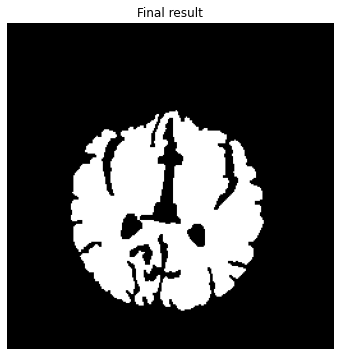

In [14]:
mask1 = np.zeros(brain_im.shape).astype(bool)
mask1[longest_c[:,0].astype(int),longest_c[:,1].astype(int)] = True

mask_longest = ndimage.binary_fill_holes(mask1)
mask_holes = np.zeros(brain_im.shape).astype(bool)

for n, contour in enumerate(contours):
    mask_temp = np.zeros(brain_im.shape).astype(bool)
    if n!=index_longest:
        if(len(contour)>60):
            mask_temp[contour[:,0].astype(int),contour[:,1].astype(int)] = True
            mask_temp = ndimage.binary_fill_holes(mask_temp)
            mask_holes = np.logical_or((mask_temp),mask_holes)

final_mask = np.logical_and(mask_longest, np.logical_not(mask_holes))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(final_mask, cmap='gray')
ax.set_title('Final result')
ax.axis('off')

plt.show()

In [15]:
print('Size of brain (in pixels) is:', np.sum(final_mask))

Size of brain (in pixels) is: 14827


Because we performed a binary erosion at the start, we see that the size of the brain (in pixels) that we get from this method is smaller than what we had gotten from the region growing method.

### 1.4 Additional method(s)

#### 1.4.1 Edge Detection

In this part, we explore how we can use an edge detection algorithm, namely, Canny edge detection to segment the brain image and compute the brain area in pixels.

The discussions, results, and the code are presented below:

In [16]:
%matplotlib inline

# Load image
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)
    
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))

To find the area of brain using Canny edge detection, we first try to split the actual brain part of the image from the background. In a preprocessing step, we denoise the image as the noise will not allow us to detect the edges properly. The reason is that, in edge detection, we rely on taking image derivatives. The proportion of noise to signal is larger at high frequencies, and taking image derivatives mostly affects high frequencies and hence amplifies noise. It is therefore prudent to smooth the image with a low-pass filter before computing the image derivatives. Because we would like the response of our edge detector to be independent of orientation, a circularly symmetric smoothing filter is desirable. Thus, the Gaussian is the only separable circularly symmetric filter and hence we use a Gaussian filter of size 7*7 to suppress the noise in the image. However, we should be aware of the trade-off here: compared to other filters such as Median filter, the Gaussian filter is forced to filter away high-frequency details, which is most noticeable near strong edges while Median filter would enable more edge-preserving smoothing.

After we apply Gaussian blur to reduce the noise in the image, we use a Circle Hough Transform to find the circle that best surrounds the brain and separates it from the skull. Hough Circle Transform finds circles of fixed radius r within the image and is, in fact, equivalent to convolution (template matching) with a circle. The Hough Circle Transform works in a roughly analogous way to the Hough Line Transform. In line detection case, a line is defined by two parameters (r, \theta). In the circle case, we need three parameters to define a circle: the coordinates (e.g., x and y) of its centre and its radius. We use cv2.HoughCircles() function of OpenCV library to detect all the circles in the image. This function takes some input parameters that are explained in the code. We tune these parameters so that erroneous circles avoided. This is done using trial and error and prior knowledge of the original image. 

In [17]:

def findBrainCircle(img):
    
    """
    Returns the circles found in the input image as well as the circles' coordiates and radii 

    Parameters
    ----------
    img : numpy.ndarray
        input image in which we would like to find the circles 
    
    Returns
    -------
    numpy.ndarray
        image with circles found in it
    list 
        list circles'center coordiates and radii

    """
    
    # Apply a gaussian blur to reduce noise and avoid false circle detection
    im = cv2.GaussianBlur(img,(7,7),0)
    #im = cv2.medianBlur(img,5)
    output = img.copy()

    # detect circles in the image so that we can detect the brain area
    
    """
    HoughCircles( src_gray, circles, CV_HOUGH_GRADIENT, 1, src_gray.rows/8, 200, 100, 0, 0 );
    with the arguments:

    src_gray: Input image (grayscale)
    circles: A vector that stores sets of 3 values: x_{c}, y_{c}, r for each detected circle.
    CV_HOUGH_GRADIENT: Define the detection method. Currently this is the only one available in OpenCV
    dp = 1: The inverse ratio of resolution
    min_dist = src_gray.rows/8: Minimum distance between detected centers
    param_1 = 200: Upper threshold for the internal Canny edge detector
    param_2 = 100*: Threshold for center detection.
    min_radius = 0: Minimum radio to be detected. If unknown, put zero as default.
    max_radius = 0: Maximum radius to be detected. If unknown, put zero as default

    """
    circles = cv2.HoughCircles(im, cv2.HOUGH_GRADIENT, 1.8, 200)

    # ensure at least some circles were found    
    if circles is not None:
        # convert circles radius and center coordinates to integer
        circles = np.round(circles[0, :]).astype("int")

        # loop over the circles' center coordinates and radii
        for (x, y, r) in circles:
            # draw the circle in the output image, then draw a rectangle
            # corresponding to the center of the circle
            cv2.circle(output, (x, y), r, (255, 0, 0), 2)
            cv2.rectangle(output, (x - 2, y - 2), (x + 2, y + 2), (255, 0, 0), -1)
            radius = r
            x_center = x
            y_center = y


    # print the results 
    #print(x_center,y_center,radius)
    return output, [radius, x_center, y_center] 



<class 'list'>


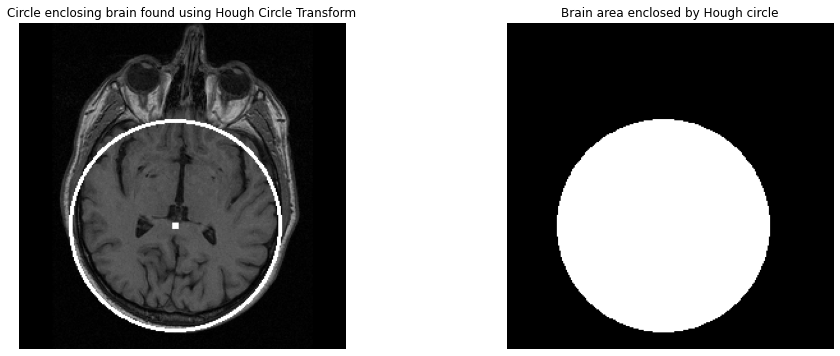

In [18]:
# find the circle outlining brain area 
output, res = findBrainCircle(brain_im)
print(type(res))
brain_area = np.zeros_like(brain_im)
brain_circle = cv2.circle(brain_area.copy(),(res[1],res[2]),res[0],(255,255,255),2)
brain_circle = binary_fill_holes(brain_circle).astype(np.uint8)

# show the output images

titles = ['Circle enclosing brain found using Hough Circle Transform', 'Brain area enclosed by Hough circle']
plots = [output, brain_circle]
fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1,3):
    ax = fig.add_subplot(1, 2, i)
    ax.imshow(plots[i-1], cmap='gray')
    ax.axis('off')
    plt.title(titles[i-1])
plt.show()

Then, we use the area within the circle as a mask and apply Canny edge detector to it to be able to detect edges only in a certain area (i.e., brain area). The Canny function of scikit-image library we use has three adjustable parameters: the width of the Gaussian applied as filter to the image (the noisier the image, the greater the width), and the low and high threshold for the hysteresis thresholding. We fine-tune the parameters so that the algorithm better captures the edge within brain area. 

Finally, we apply a morphological operation, namely dilation, to the Canny image to be able to more accurately detect brain edges. Dilation links the edges that are close enough to each other and thus we will have a coherent connected component which that better captures the brain area.

In [19]:
def cannyEdgeDetector(im, sigma):
    """
    Returns edges detected in the (brain) input image using the parameters provided at input using Canny edge
    detection as well as aera of brain in pixels

    Parameters
    ----------
    im : numpy.ndarray
        input image in which we would like to apply Canny edge detection
    sigma: float
        sigma of Gaussian filter
    
    Returns
    -------
    numpy.ndarray
        Canny edge detection result image
    numpy.ndarray 
        full image 
    int 
        size of detected area 

    """
    # use canny filter to detect edges in brain circle
    canny_filtered_img = canny(brain_im.copy(), sigma=sigma, mask = brain_circle.astype(bool)) 

    # applying dilation to brain area
    kernel = np.ones((4,4))
    brain_area_edges = cv2.morphologyEx(canny_filtered_img.astype(np.uint8), cv2.MORPH_DILATE, kernel, iterations = 1)
    removed = 1 - binary_fill_holes(brain_area_edges).astype(np.uint8)
    masked_image = removed & brain_circle
    only_brain = morphology.remove_small_objects(masked_image.astype(bool), min_size=900).astype(np.uint8)
    finalEdges = cv2.morphologyEx(only_brain, cv2.MORPH_DILATE, kernel, iterations = 1)
    
    # measure brain area in pixels
    size = np.sum(finalEdges)
    
    full_img = brain_im | (finalEdges*255)
    return canny_filtered_img, full_img, size

The size of brain (in pixels) is: 14640


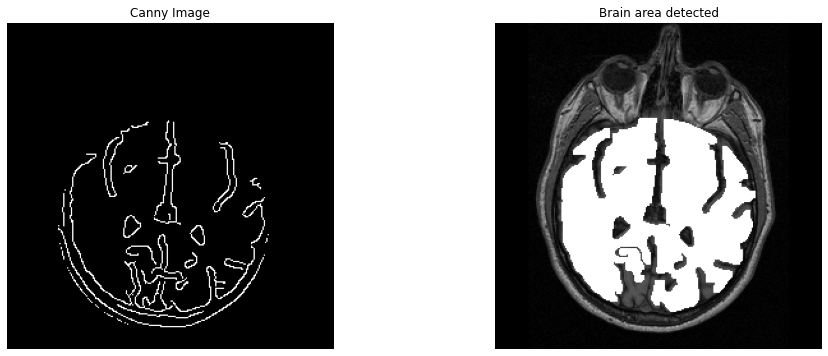

In [20]:
img = brain_circle.copy()
canny_img,full_img,size = cannyEdgeDetector(img,1.7)
print('The size of brain (in pixels) is: {}'.format(size))

# show the output images
titles = ['Canny Image','Brain area detected']
plots = [canny_img, full_img]
fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1,3):
    ax = fig.add_subplot(1, 2, i)
    ax.imshow(plots[i-1], cmap='gray')
    ax.axis('off')
    plt.title(titles[i-1])
plt.show()

Even after fine-tuning the parameters such as Canny edge detector parameters, as well as the parameters related to the circle found by Hough Transform, this method does not give accurate results and we are not able to precisely detect all brain areas as it can be seen in the results and the computed brain area is significantly smaller th. 

#### 1.4.2 Snakes: Active Contours Method
Active contour is a type of segmentation technique which can be defined as use of energy forces and constraints for segregation of the pixels of interest from the image for further processing and analysis. 
Here we study 'snake' model of active contours. A snake is an energy-minimizing spline guided by external constraint forces and influenced by image forces that pull it toward edges.

First, we define initial spline for the active contour method in order to include the entire brain. For this end, we consider a circle which contains the brain as shown with yello dash on figure bellow.
Afterwards, we apply gaussian blur with 3by3 kernel to the image to reduce the noise effect, and feed in the filtered image to _Skimage_ 'active contour model'.
This module requires input parameters including:
- _alpha_ is the length shape parameter of snake spline. Higher _alpha_ values makes snake contract faster. 
- _beta_ is the smoothness parameter of the spline. Higher _beta_ means that the snake spline is smoother.
- _w_line_ and _w_edge_ are the parameter that controls attraction to brightness and edges in order. 

Initially our attempt to tune the parameters of the snake spline to be able to fit it directly to the brain was not successful. Neverthless, we could acuire the first contour that detects the edges of the skull as shown bellow.  


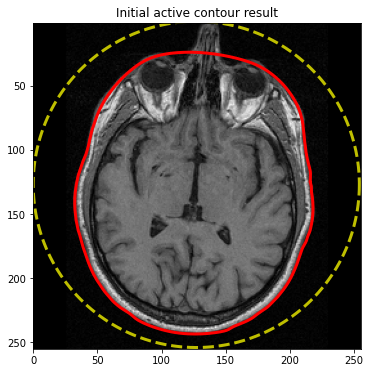

In [21]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
img = brain_im

s = np.linspace(0, 2*np.pi, 400)
r = 127 + 127*np.sin(s)
c = 127 + 127*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(gaussian(img, 3),
                       init, alpha=0.015, beta=10, gamma=0.001, w_line=0, w_edge=1,
                       coordinates='rc')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--y', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=3)
ax.axis([0, img.shape[1]-1, img.shape[0]-1, 1])
ax.set_title('Initial active contour result')

# Convert the contour into a closed path
closed_snake = path.Path(snake)
# Get the points that lie within the closed path
idx = np.array([[(j,i) for i in range(img.shape[0])] for j in range(img.shape[1])]).reshape(np.prod(img.shape),2)
# mask_snake = binary image True inside the snake
mask_snake = closed_snake.contains_points(idx).reshape(img.shape)

We realized that this method is sensative to the initial contour and fine tuning of the input parameters. Thus, we provided the detected skull spline at first step as the initial contour for the second attempt. This time after gaussina blurring, we also binarize and erode the input image in order to make the edges between the skull and the brain more distinguishable. Moreover, we realized that the method is adjusted by either repulsion degree to the darkness. Therefore, we also whiten the background to cancel its effect from contour detection.  


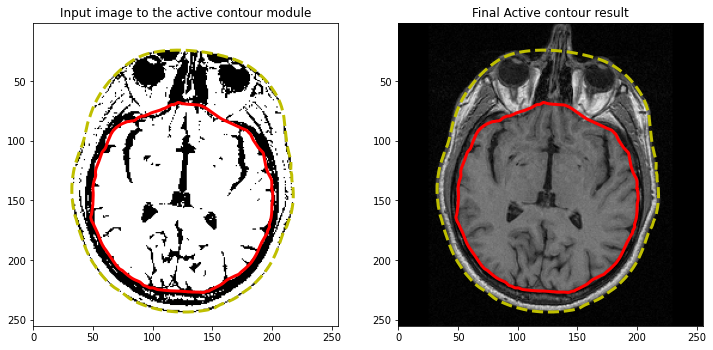

Size of brain (in pixels) is: 18841


In [22]:
plt.close()
img2 = brain_im
img2 = skimage.filters.gaussian(img2,sigma=0.01)
img2 = morphology.binary_erosion(img2 > 0.2, selem=np.ones([1,1]))
img2= img2+~mask_snake


s = np.linspace(0, 2*np.pi, 400)
r = 127 + 127*np.sin(s)
c = 127 + 127*np.cos(s)
init = np.array([r, c]).T


snake1 = active_contour(gaussian(img2, 3),
                       snake, alpha=1, beta=10, gamma=0.001, w_line=-1, w_edge=2,convergence=0.01, boundary_condition='periodic',
                       coordinates='rc')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img2, cmap=plt.cm.gray)
ax[0].plot(snake[:, 1], snake[:, 0], '--y', lw=3)
ax[0].plot(snake1[:, 1], snake1[:, 0], '-r', lw=3)
ax[0].axis([0, img.shape[1]-1, img.shape[0]-1, 1])
ax[0].set_title('Input image to the active contour module')

ax[1].imshow(brain_im, cmap=plt.cm.gray)
ax[1].plot(snake[:, 1], snake[:, 0], '--y', lw=3)
ax[1].plot(snake1[:, 1], snake1[:, 0], '-r', lw=3)
ax[1].axis([0, img.shape[1]-1, img.shape[0]-1, 1])
ax[1].set_title('Final Active contour result')
plt.show()

# Convert the contour into a closed path
closed_snake1 = path.Path(snake1)
# Get the points that lie within the closed path
idx = np.array([[(j,i) for i in range(img2.shape[0])] for j in range(img2.shape[1])]).reshape(np.prod(img2.shape),2)
# mask_snake = binary image True inside the snake
mask_snake1 = closed_snake1.contains_points(idx).reshape(img2.shape)

print('Size of brain (in pixels) is:', np.sum(mask_snake1))

Comparing the detected size of brain with previous methods indicates that there are some irrelevant points detected by
 this method. The detected contour shown by red color also clarifies that Active contour method is not capable of
 distinguishing the small holes and striated irrelavant area inside the brain.

#### 1.4.3 K-Nearest Neighbours Clustering

In this section we segments image using k-means clustering in grayscale as well as (x,y) space.
First we denoise the brain image by gaussian filter with a suitable variance.
Next, we balance color proximity and space proximity with a factor (i.e 'compactness').
We specify large enough number of clusters and select the cluster containing the interested parts. 
Afterwards, we open the resultant image and use an appropriate threshold for its grayscale
value. The results after each step are shown bellow.


Size of brain (in pixels) is: 16198


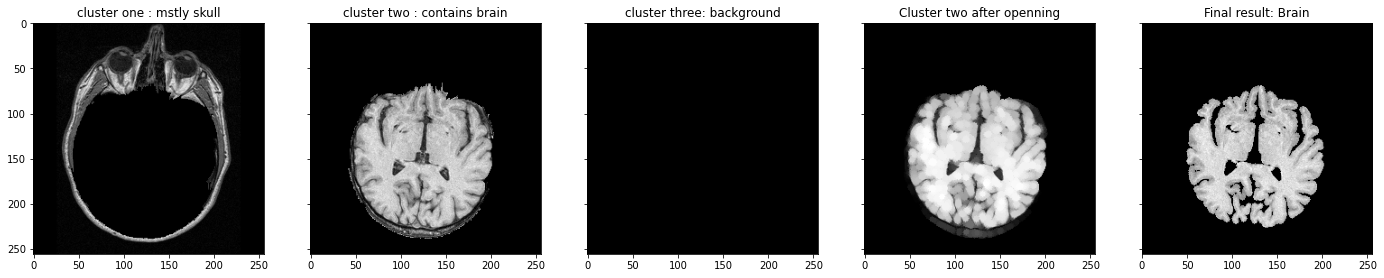

In [23]:
from skimage import data, io, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True,
                       figsize=(24, 24))

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))

img = brain_im

labels1 = segmentation.slic(img, compactness=.01, n_segments=4,  min_size_factor=0.6, sigma=.1)
img2_0=np.multiply(img,(labels1==0)*1)
ax[0].imshow(img2_0, cmap='gray')
ax[0].set_title('cluster one : mstly skull')
img2_1=np.multiply(img,(labels1==1)*1)
ax[1].imshow(img2_1, cmap='gray')
ax[1].set_title('cluster two : contains brain')
img2_2=np.multiply(img,(labels1==2)*1)
ax[2].imshow(img2_2, cmap='gray')
ax[2].set_title('cluster three: background')
img2_3=np.multiply(img,(labels1==3)*1)
img2_1 = morphology.opening(img2_1, morphology.disk(3)) 
ax[3].imshow(img2_1, cmap='gray')
ax[3].set_title('Cluster two after openning')
thresh=49
img2_1=np.multiply(img,(img2_1>thresh)*1)
ax[4].imshow(img2_1, cmap='gray')
ax[4].set_title('Final result: Brain')

print('Size of brain (in pixels) is:', np.sum(img2_1!=0))

According to the results, we could successfully extract the brain out of
the skull and background using k-nearest neighbours unsupervised learning algorithm.

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [24]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


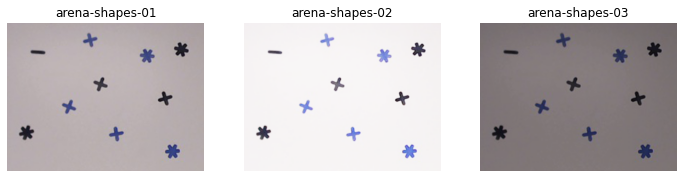

In [25]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color

First of all we reduce the illumination impact on our analysis. To do so we convert the image to HSV color space. 
Then, we shift the brightness channel mean of each image to the maximum value and truncate the brightness more than the 
maximum 100 percent.

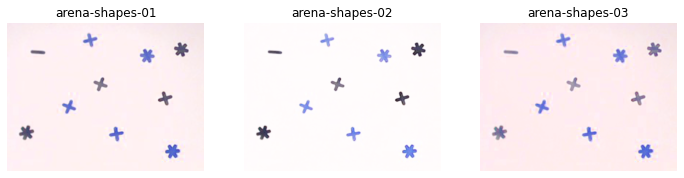

In [26]:
def illumination_invariance(im):
    hsv_im = rgb2hsv(im)
    temp = np.ones(hsv_im[:,:,2].shape)
    hsv_im[:,:,2] = np.minimum(hsv_im[:,:,2]+(1-np.mean(hsv_im[:,:,2])), temp)
    return hsv2rgb(hsv_im)


fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    im1 = illumination_invariance(im)
    ax.imshow((im1))
    ax.axis('off')
    ax.set_title(nm)

plt.show()

Comparing the resultant images with the original ones indicates that the illumination variance in between them has been 
reduced; however, there is still difference in the illumination. To decrease the illumination difference further we 
take the average of mean values of brightness channel for three images. Afterwards, we shift the mean value of brightness channel
for each image to the calculated average brightness, and add a constant offset to have brighter result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


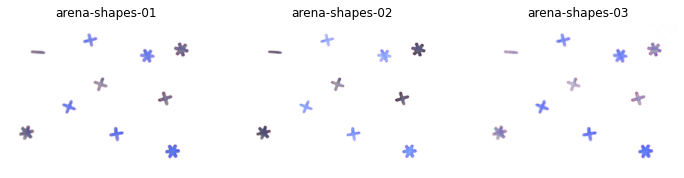

In [27]:
mean_V=np.empty(3)
std_V=np.empty(3)

def Value_info(im):
    hsv_im = rgb2hsv(im)
    _mean = np.mean(hsv_im[:,:,2])
    _std = np.std(hsv_im[:,:,2])
    return _mean, _std

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
count=0
for im in images:
    mean_V[count], std_V[count] = Value_info(im)
    count+=1

def illumination_invariance_2(im):
    hsv_im = rgb2hsv(im)
    hsv_im[:,:,2] = hsv_im[:,:,2]-(np.mean(hsv_im[:,:,2])-mean_V.mean())+0.4
    return hsv2rgb(hsv_im)

for ax, im, nm in zip(axes.ravel(), images, im_names):
    im1 = illumination_invariance_2(im)
    ax.imshow((im1))
    ax.axis('off')
    ax.set_title(nm)

plt.show()

The results confirm that the illumination variance between input images has further decreased. Then we binarize
the image to have background and objects. Thereafter, we label connected regions of the binary image array.
 Two pixels are connected when they are neighbors and have the same value. Then we find the mean color value 
 inside each labeled object. We use euclidean distance with an appropriate threshold to distnigush and
 count the objects with different colors.

In [28]:
def count_shapes_2(image, gray_thresh, dist_thresh):
    img = illumination_invariance_2(image)
    mask = skimage.color.rgb2gray(img)<gray_thresh
    
    blobs_labels = measure.label(mask, background=0)
    
    labels = np.sort(np.unique(blobs_labels.ravel()))[1:]
    seen_colors = []
    count_shapes_2 = []
    for i in labels:
        mask1 = [blobs_labels==i]
        rgb_mean = np.mean(img[tuple(mask1)], axis=0)
        seen_colors.append(rgb_mean)
        
    count1 = np.sum(distance.cdist(seen_colors, seen_colors)[0,:] > dist_thresh)
    count2 = len(labels) - count1
    return count1, count2

for ind, i in enumerate(images):
    print('For image',ind,'number of shapes of each color: ',count_shapes_2(i, gray_thresh=0.88, dist_thresh=0.2))

For image 0 number of shapes of each color:  (5, 5)
For image 1 number of shapes of each color:  (5, 5)
For image 2 number of shapes of each color:  (5, 5)


According to the results, for each image 5 objects have same color and 5 other
objects have another color. The results demonstrate the validity of the routine.

### 2.3 Total area (in pixels) of each color


Here we sum all pixels inside objects with identical colors after detection of objects with improved illumination invariance strategy that we proposed.
We also close the masked image to ignore small holes created during illumination invariance. Finally, number of pixels per each color is printed. The area is equal to the each value multiply by the area of each pixel.
Ideally area of objects with same color for each pictures should be equal. To evaluate the result we define an error between areas with same colors between each pictures.


In [29]:
def count_area_2(image, gray_thresh, dist_thresh):
    img = illumination_invariance_2(image)
    mask = skimage.color.rgb2gray(img)<gray_thresh
    mask = morphology.closing(mask, morphology.square(5)) 
    
    blobs_labels = measure.label(mask, background=0)
    
    labels = np.sort(np.unique(blobs_labels.ravel()))[1:]
    seen_colors = []
    count_shapes = []
    for i in labels:
        mask1 = [blobs_labels==i]
        rgb_mean = np.mean(img[tuple(mask1)], axis=0)
        seen_colors.append(rgb_mean)
        
    colors = (distance.cdist(seen_colors, seen_colors)[0,:] > dist_thresh)
    color1_labels = np.nonzero(colors)[0]+1
    color2_labels = np.nonzero(np.logical_not(colors))[0]+1
    
    num_pixels1 = 0
    num_pixels2 = 0
    
    for i in color1_labels:
        num_pixels1 += np.sum(blobs_labels==i)
    for i in color2_labels:
        num_pixels2 += np.sum(blobs_labels==i)
        
    return num_pixels1, num_pixels2

In [30]:
area = np.empty([3,2])
for ind, i in enumerate(images):
    area[ind,0], area[ind,1] = count_area_2(i,0.8,0.2)
    print('For image',ind,'number of pixels of each color: ', area[ind, :])
    
_error=abs(area[0,:]-area[1,:])+abs(area[0,0]-area[2,:])+abs(area[1,:]-area[2,:])
error_percent=_error/area.sum(0)*100
print('Fist color area error = {:.1f} %'.format(error_percent[0]))
print('Second color area error = {:.1f} %'.format(error_percent[1]))

For image 0 number of pixels of each color:  [4853. 5105.]
For image 1 number of pixels of each color:  [4438. 4202.]
For image 2 number of pixels of each color:  [4400. 4993.]
Fist color area error = 6.6 %
Second color area error = 12.8 %


According to the results, our defined error is between 6 to 12 percent for each color. This is due to the illumination
variance between the pictures; however, small error values per each color demonstrates the functionality of our illumination invariance strategy.